In [1]:
%load_ext autoreload
%autoreload 2

import typing
import random
import anaconfig
import os
import os.path as op
import glob

from tqdm.auto import tqdm
import numpy.typing as npt
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils.commonutils.crun import run_for_different_partitions
from utils.commonutils.config import (
    get_pipeline_config_path,cdirs, load_config, resolve_config_paths
)
from utils.commonutils.ctests import get_required_test_dataset_names
from utils.plotutils.plotconfig import configure_matplotlib
from Preprocessing.particle_fitting_metrics import compute_particle_line_metrics_dataframe
from scripts.evaluate import evaluate_partition

configure_matplotlib()


In [2]:
data_experiment_dir = op.join(
    cdirs.data_directory, "scifi-3-xuvx-reconstructible", "preprocessed",
)

In [3]:
event_ids = []
paths = os.scandir(data_experiment_dir)
while len(event_ids) < 1000:
    path = next(paths)
    event_id = path.name[len("event"): len("event") + 18]
    if event_id not in event_ids:
       event_ids.append(event_id)


In [4]:
particle_paths = [
    op.join(data_experiment_dir, f"event{event_id}-particles.parquet") for event_id in event_ids
]

hit_paths = [
    op.join(data_experiment_dir, f"event{event_id}-hits_particles.parquet") for event_id in event_ids
]


In [5]:
def load_dataframes(paths: typing.List[str], columns: typing.List[str]):
   return pd.concat(
       [
           pd.read_parquet(path, columns=columns)
           for path in tqdm(paths)
       ],
       axis=0,
   )


df_particles = load_dataframes(
    paths=particle_paths,
    columns=["event_id", "particle_id", "p", "pt", "phi", "eta", "has_velo", "has_scifi", "pid"],
)
df_hits_particles = load_dataframes(
    paths=hit_paths,
    columns=["event_id", "hit_id", "particle_id", "xatyeq0", "zatyeq0", "dxdy", "plane"],
)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

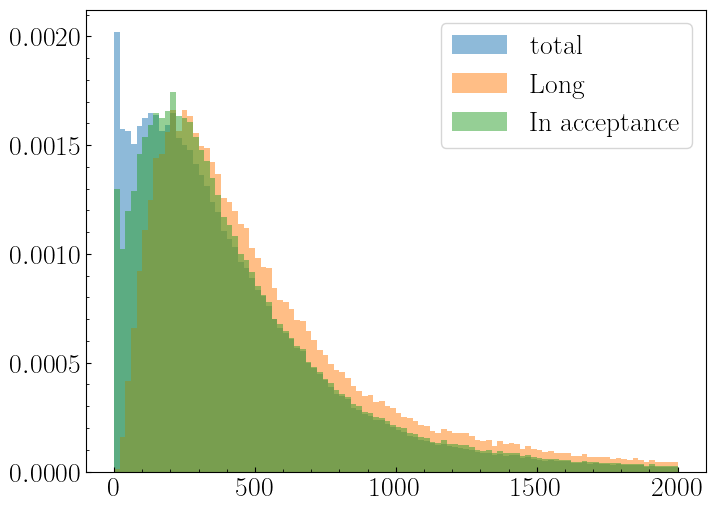

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

in_acceptance_mask = (df_particles["eta"] > 2.0) & (df_particles["eta"] < 5.0)
long_mask = df_particles["has_velo"] & df_particles["has_scifi"]

min_max = (0, 2000)

ax.hist(df_particles[df_particles["has_scifi"]]["pt"], range=min_max, bins=100, label="total", alpha=0.5, density=True)
ax.hist(df_particles[long_mask]["pt"], range=min_max, bins=100, label="Long", alpha=0.5, density=True)
ax.hist(df_particles[in_acceptance_mask]["pt"], range=min_max, bins=100, label="In acceptance", alpha=0.5, density=True)
ax.minorticks_on()
ax.legend()

In [24]:
df_quadratic_coeffs = compute_particle_line_metrics_dataframe(
    hits=df_hits_particles[df_hits_particles["dxdy"] == 0],
    metric_names=["quadratic_coeff"],
    coord_names=["zatyeq0", "xatyeq0"],
    line_type="quadpoly_2d",
)

In [25]:
df_particles = df_particles.merge(
    df_quadratic_coeffs.reset_index(),
    how="left",
    on=["event_id", "particle_id"],
)

In [26]:
def compute_n_shared_hits(
    df_hits_particles: pd.DataFrame, df_particles: pd.DataFrame
) -> pd.DataFrame:
    df_hits_particles = df_hits_particles[df_hits_particles["particle_id"] != 0].merge(
        df_particles[["event_id", "particle_id", "has_scifi"]],
        on=["event_id", "particle_id"],
        how="left",
    )
    df_hits_particles = df_hits_particles[df_hits_particles["has_scifi"]]
    
    n_particles_per_hit = (
        df_hits_particles.groupby(["event_id", "hit_id"])["particle_id"]
        .count()
        .rename("n_particles_per_hit")
    )

    df_hits_particles = df_hits_particles.merge(
        n_particles_per_hit.reset_index(),
        on=["event_id", "hit_id"],
        how="left",
    )
    df_hits_particles["more_than_1_particle"] = (
        df_hits_particles["n_particles_per_hit"] >= 2
    )
    df_particles = df_particles.merge(
        df_hits_particles.groupby(["event_id", "particle_id"])["more_than_1_particle"]
        .sum()
        .rename("n_shared_hits")
        .fillna(0),
        how="left",
        on=["event_id", "particle_id"],
    )
    return df_particles

df_particles = compute_n_shared_hits(df_hits_particles, df_particles)

In [46]:
df_particles["pz"] = np.sqrt(df_particles["p"] ** 2 - df_particles["pt"] ** 2)
df_particles["px"] = df_particles["pt"] * np.cos(df_particles["phi"])
df_particles["px_p_pz"] = df_particles["px"] + df_particles["pz"]

Text(0, 0.5, 'Quadratic coefficient')

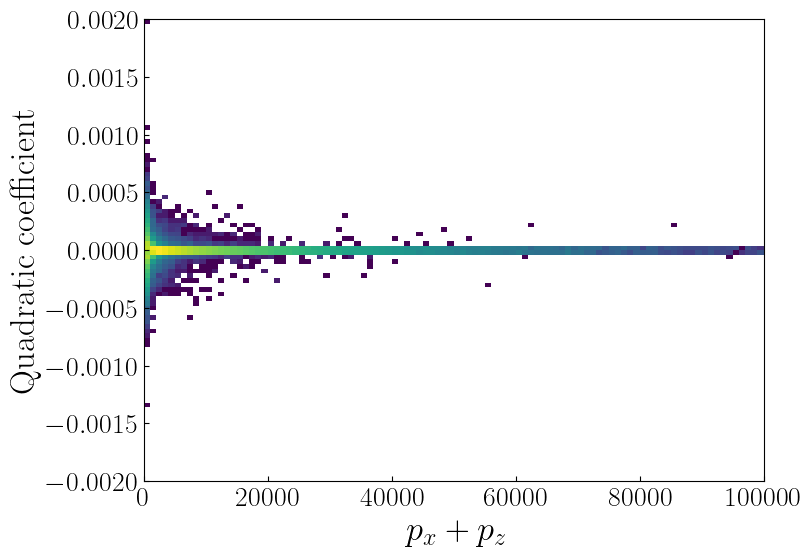

In [47]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles["px_p_pz"],
    y=df_particles["quadratic_coeff"],
    bins=100,
    range=((0, 100000), (-0.002, 0.002)),
     norm=mpl.colors.LogNorm(),
)
ax.set_xlabel("$p_x + p_z$")
ax.set_ylabel("Quadratic coefficient")



Text(0, 0.5, 'Quadratic coefficient')

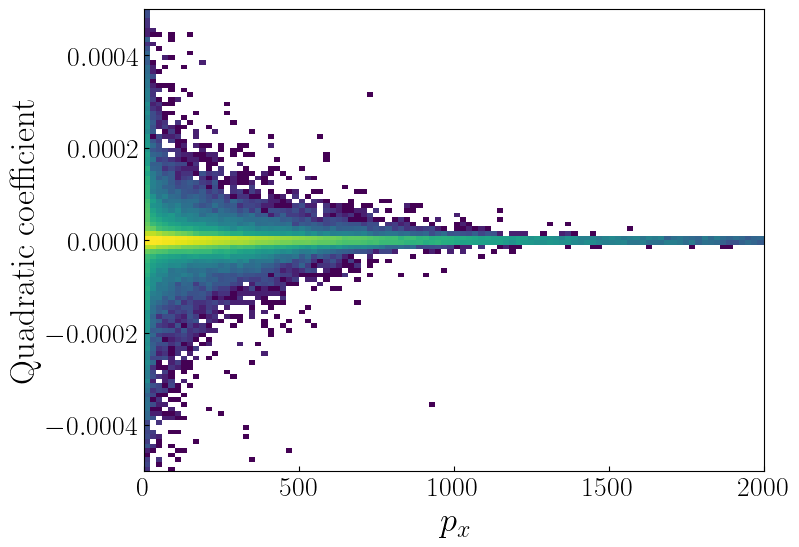

In [49]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles["px"],
    y=df_particles["quadratic_coeff"],
    bins=100,
    range=((0, 2000), (-0.0005, 0.0005)),
    norm=mpl.colors.LogNorm(),
)
ax.set_xlabel("$p_x$")
ax.set_ylabel("Quadratic coefficient")



In [63]:
df_particles_long = df_particles[df_particles["has_velo"]]

In [66]:
(df_particles_long["quadratic_coeff"] < 6.5e-06).sum() / df_particles_long.shape[0]

0.8788009865999117

Text(0, 0.5, 'Quadratic coefficient')

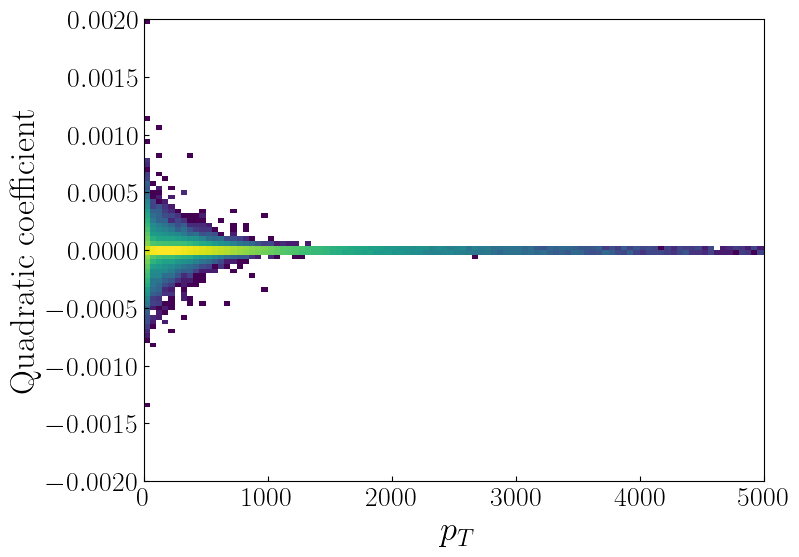

In [50]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles["pt"],
    y=df_particles["quadratic_coeff"],
    bins=100,
    range=((0, 5000), (-0.002, 0.002)),
     norm=mpl.colors.LogNorm(),
)
ax.set_xlabel("$p_T$")
ax.set_ylabel("Quadratic coefficient")



In [51]:
df_particles["pl"] = np.sqrt(
    np.square(df_particles["p"]) - np.square(df_particles["pt"])
)


Text(0, 0.5, 'Quadratic coefficient')

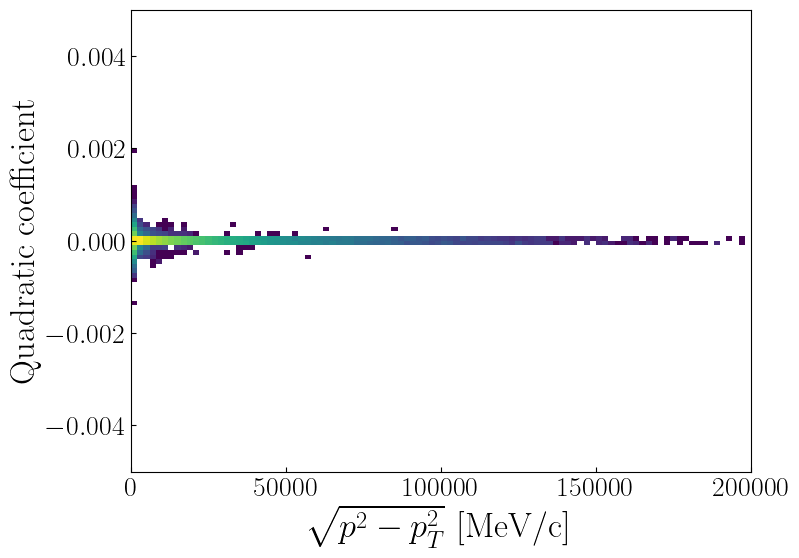

In [52]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles["pl"],
    y=df_particles["quadratic_coeff"],
    bins=100,
    range=((0, 200000), (-0.005, 0.005)),
     norm=mpl.colors.LogNorm(),
)
ax.set_xlabel(r"$\sqrt{p^2 - p_T^2}$ [MeV/c]")
ax.set_ylabel("Quadratic coefficient")



Text(0, 0.5, 'Quadratic coefficient')

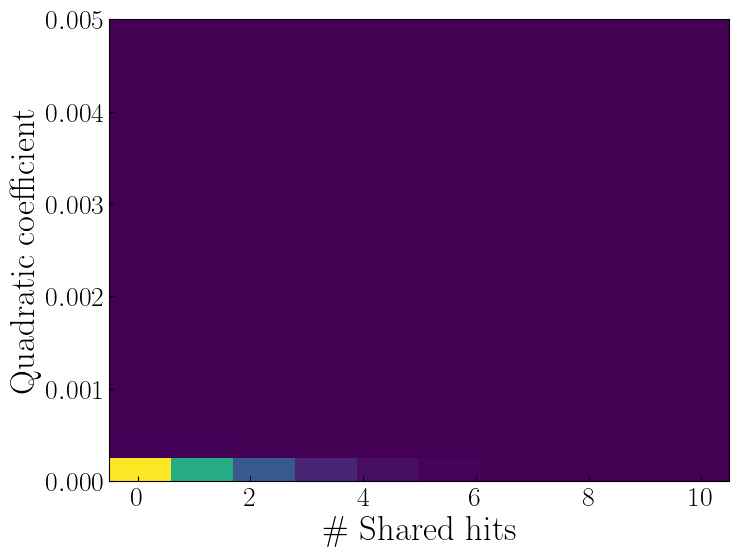

In [53]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles["n_shared_hits"],
    y=df_particles["quadratic_coeff"],
    bins=[10, 20],
    range=((-0.5, 10.5), (0.0, 0.005)),
    # norm=mpl.colors.LogNorm(),
)
ax.set_xlabel(r"\# Shared hits")
ax.set_ylabel("Quadratic coefficient")



Text(0, 0.5, 'Quadratic coefficient')

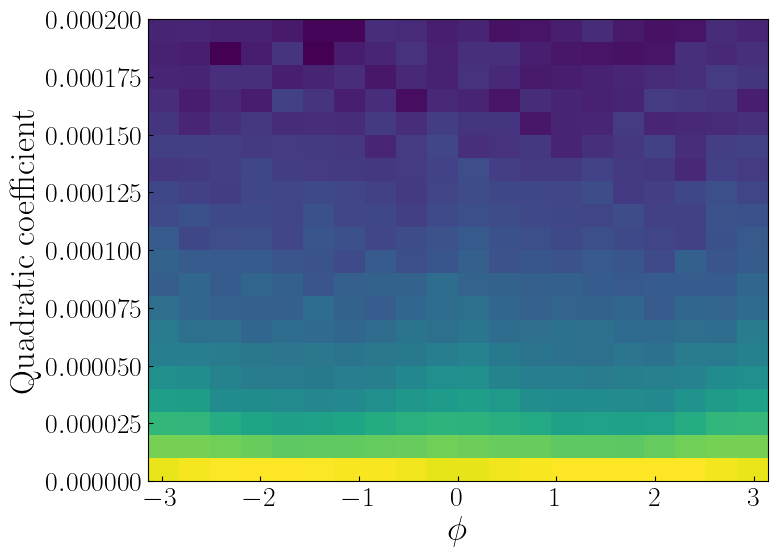

In [54]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles["phi"],
    y=df_particles["quadratic_coeff"].abs(),
    bins=20,
    range=((-np.pi, np.pi), (0.0, 0.0002)),
    norm=mpl.colors.LogNorm(),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel("Quadratic coefficient")



Text(0, 0.5, '$p_x$')

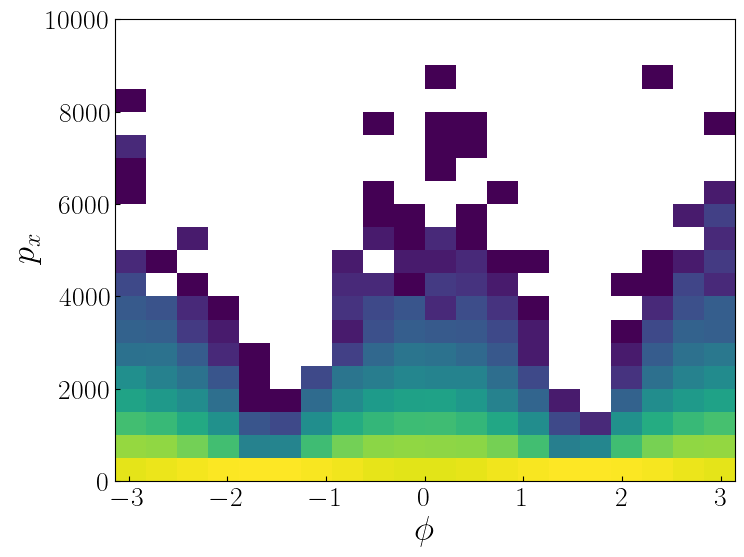

In [58]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles[df_particles["has_scifi"]]["phi"],
    y=df_particles[df_particles["has_scifi"]]["px"].abs(),
    bins=20,
    range=((-np.pi, np.pi), (0.0, 10000)),
    norm=mpl.colors.LogNorm(),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel("$p_x$")



Text(0, 0.5, '$p_T$')

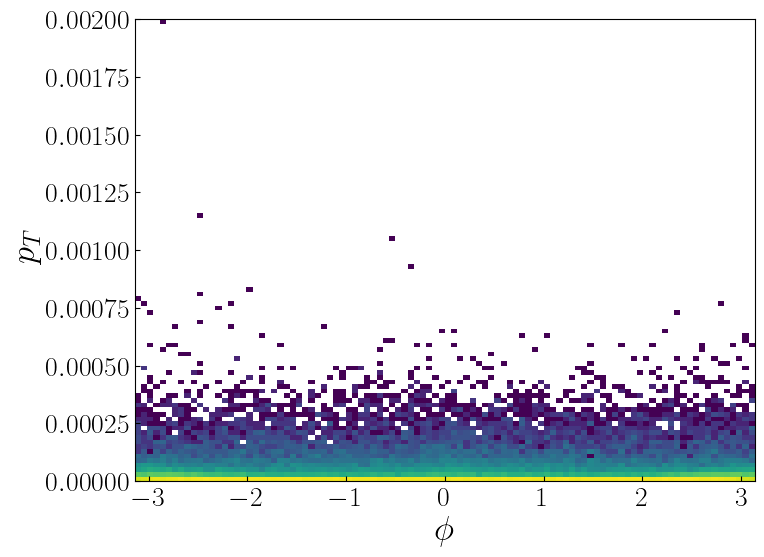

In [35]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist2d(
    x=df_particles["phi"],
    y=df_particles["quadratic_coeff"],
    bins=100,
    range=((-np.pi, np.pi), (0.0, 0.002)),
    norm=mpl.colors.LogNorm(),
)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel("$p_T$")



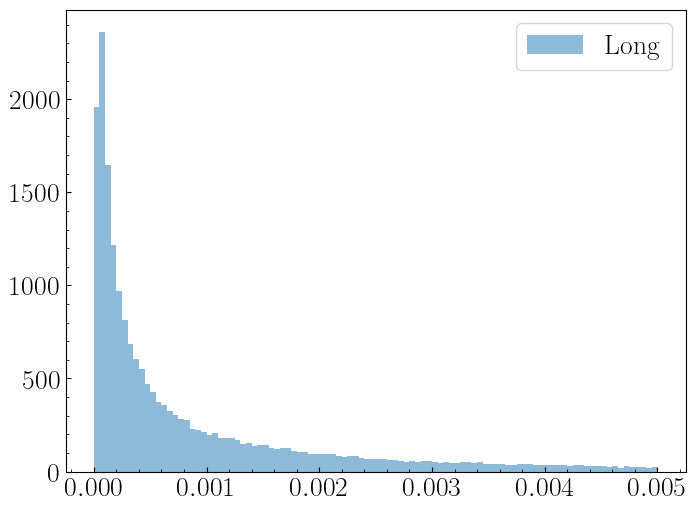

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

in_acceptance_mask = (df_particles["eta"] > 2.0) & (df_particles["eta"] < 5.0)
long_mask = df_particles["has_velo"] & df_particles["has_scifi"]

min_max = (0, 0.005)

# ax.hist(df_particles[df_particles["has_scifi"]]["quadratic_coeff"].abs(), range=min_max, bins=100, label="total", alpha=0.5, density=True)
ax.hist(df_particles[long_mask & in_acceptance_mask & (df_particles["pid"].abs() != 11)]["quadratic_coeff"].abs(), range=min_max, bins=100, label="Long", alpha=0.5, density=True)
# ax.hist(df_particles[in_acceptance_mask]["quadratic_coeff"].abs(), range=min_max, bins=100, label="In acceptance", alpha=0.5, density=True)
ax.minorticks_on()
ax.legend()

In [47]:
df_particles["abs_quadratic_coeff"] = df_particles["quadratic_coeff"].abs()

In [48]:
df_particles_long = df_particles[df_particles["has_scifi"] & df_particles["has_velo"] & df_particles["pid"].abs() != 11]


In [49]:
(df_particles_long["abs_quadratic_coeff"] > 0.7*1e-5).sum() / df_particles_long.shape[0]

0.9943700283718283

In [50]:
from numpy.polynomial.polynomial import Polynomial

def plot_xz_graph(
    df_hits_particles: pd.DataFrame,
    n_tracks: int,
    n_events: int = 10,
    seed: int | None = None,
    remove_tilted: bool = True,
    polyfit: bool = False,
):
    fig, ax = plt.subplots(figsize=(8, 6))

    event_ids = df_hits_particles["event_id"].unique()

    rng = np.random.default_rng(seed=seed)
    rng.shuffle(event_ids)

    if remove_tilted:
        df_hits_particles = df_hits_particles[df_hits_particles["dxdy"] == 0.0]

    for idx, (_, hits_particle) in enumerate(
        df_hits_particles[
            df_hits_particles["event_id"].isin(event_ids[:n_events])
            & df_hits_particles["particle_id"]
            != 0
        ].groupby(by=["event_id", "particle_id"])
    ):
        hit_coordinates = hits_particle.sort_values(by="plane")

        lines = ax.plot(
            hit_coordinates["zatyeq0"],
            hit_coordinates["xatyeq0"],
            linestyle="" if polyfit else "-",
            markersize=5.0,
            marker="o",
        )
        if polyfit:
            not_tilted_hit_coordinates = hit_coordinates[hit_coordinates["dxdy"] == 0.0]
            polynomial = Polynomial.fit(
                x=not_tilted_hit_coordinates["zatyeq0"],
                y=not_tilted_hit_coordinates["xatyeq0"],
                deg=2,
            )
            ax.plot(
                *polynomial.linspace(
                    n=100,
                    domain=[
                        hit_coordinates["zatyeq0"].min(),
                        hit_coordinates["zatyeq0"].max(),
                    ],
                ),
                linestyle="--",
                color=lines[0].get_color(),
            )
    
        if idx > n_tracks:
            break

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_xlim(
        (
            df_hits_particles["zatyeq0"].min() - 100,
            df_hits_particles["zatyeq0"].max() + 100,
        )
    )
    ax.set_ylim(
        (df_hits_particles["xatyeq0"].min(), df_hits_particles["xatyeq0"].max())  # type: ignore
    )
    return fig


In [51]:
df_hits_particles_true = df_hits_particles[df_hits_particles["particle_id"] != 0].merge(
    df_particles,
    how="left",
    on=["event_id", "particle_id"],
)

In [52]:
df_particles_true = df_hits_particles_true[["event_id", "particle_id", "has_velo", "has_scifi"]].drop_duplicates(["event_id", "particle_id"])

In [53]:
(df_particles_true["has_scifi"] & df_particles_true["has_velo"]).sum() / (df_particles_true["has_scifi"] & (~df_particles_true["has_velo"])).sum()

0.7809955076370171

In [54]:
df_hits_particles_true["abs_quadratic_coeff"] = df_hits_particles_true["quadratic_coeff"].abs()

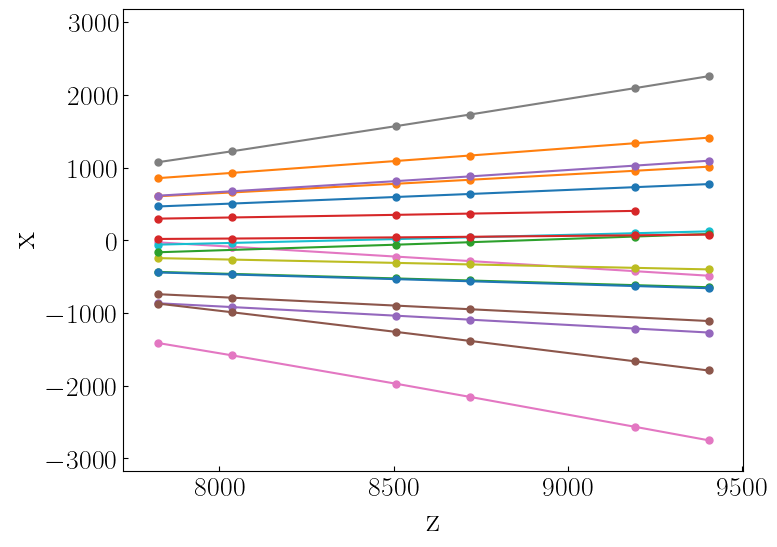

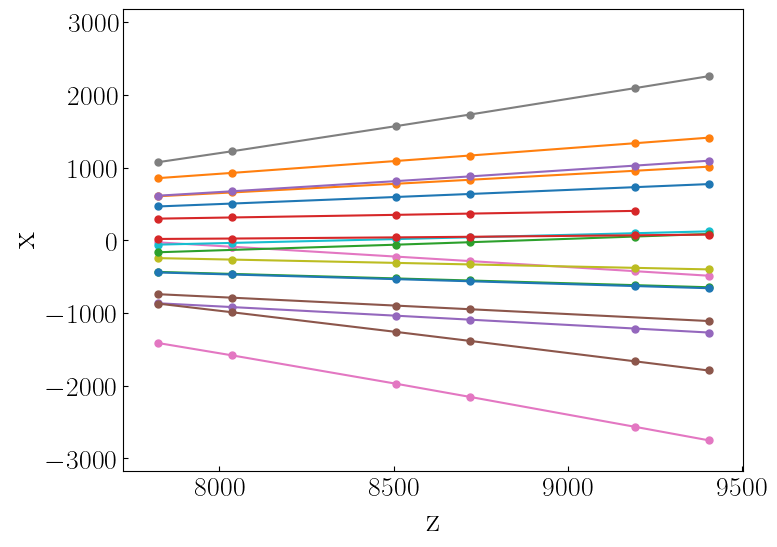

In [75]:
plot_xz_graph(
    df_hits_particles_true[df_hits_particles_true["has_scifi"] & (df_hits_particles_true["pt"] < 1000)],
    n_tracks=15,
    n_events=2,
)

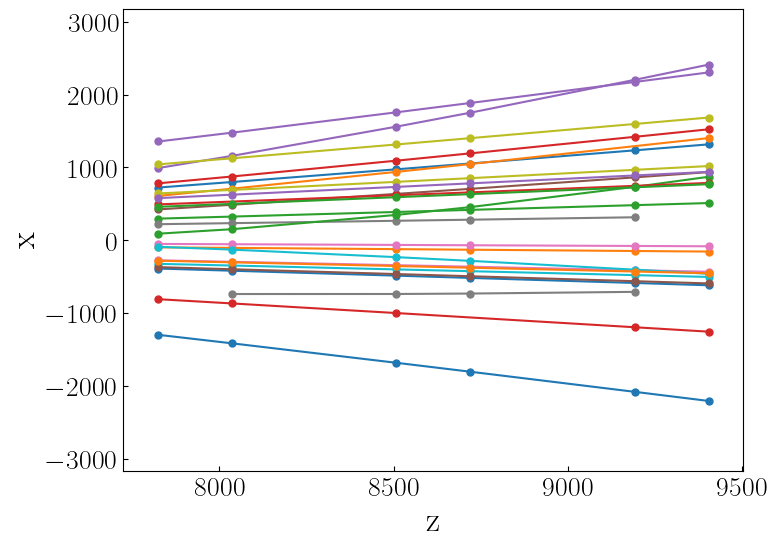

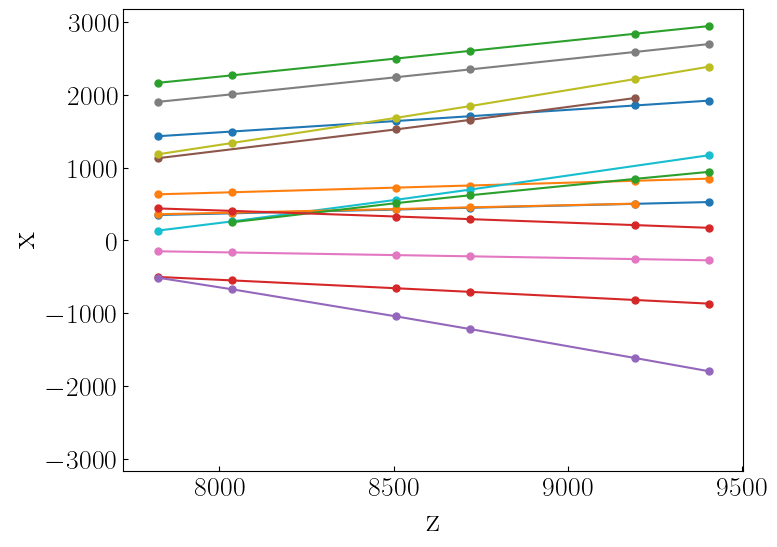

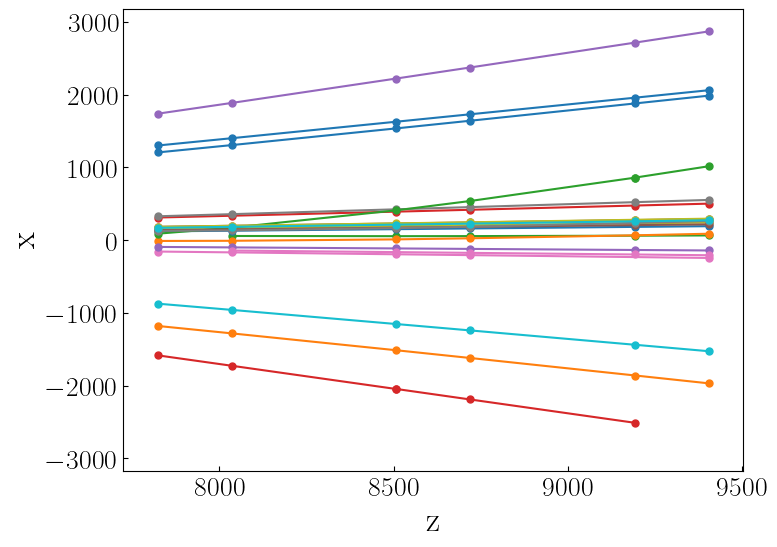

In [56]:
plot_xz_graph(
    df_hits_particles_true[df_hits_particles_true["has_scifi"] & (df_hits_particles_true["phi"] > np.pi/ 2*0.9) & (df_hits_particles_true["phi"] < np.pi/ 2*1.1)],
    n_tracks=10000,
    n_events=4,
);
plot_xz_graph(
    df_hits_particles_true[df_hits_particles_true["has_scifi"] & (df_hits_particles_true["phi"] > -0.1) & (df_hits_particles_true["phi"] < 0.1)],
    n_tracks=10000,
    n_events=4,
);

plot_xz_graph(
    df_hits_particles_true[df_hits_particles_true["has_scifi"] & (df_hits_particles_true["phi"] > -np.pi/ 2*1.1) & (df_hits_particles_true["phi"] < -np.pi / 2*0.9)],
    n_tracks=10000,
    n_events=4,
);

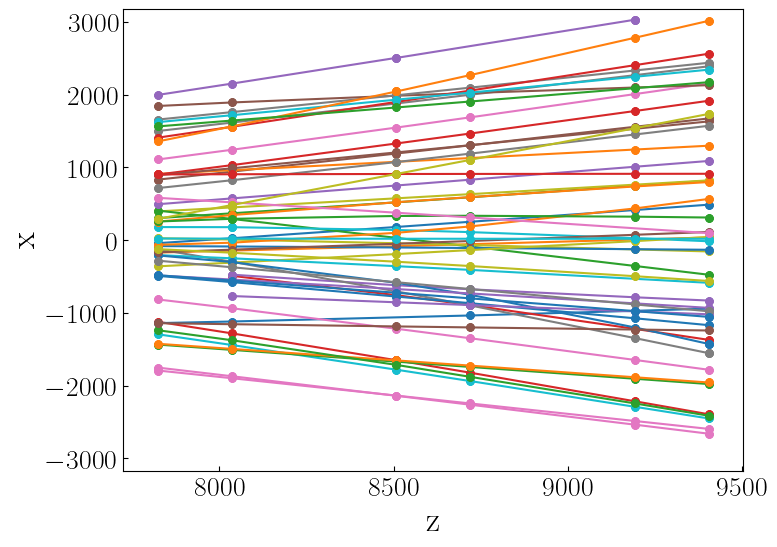

In [82]:
plot_xz_graph(
    df_hits_particles_true[df_hits_particles_true["has_scifi"] & (df_hits_particles_true["eta"] < 3)],
    n_tracks=100,
    n_events=1,
);

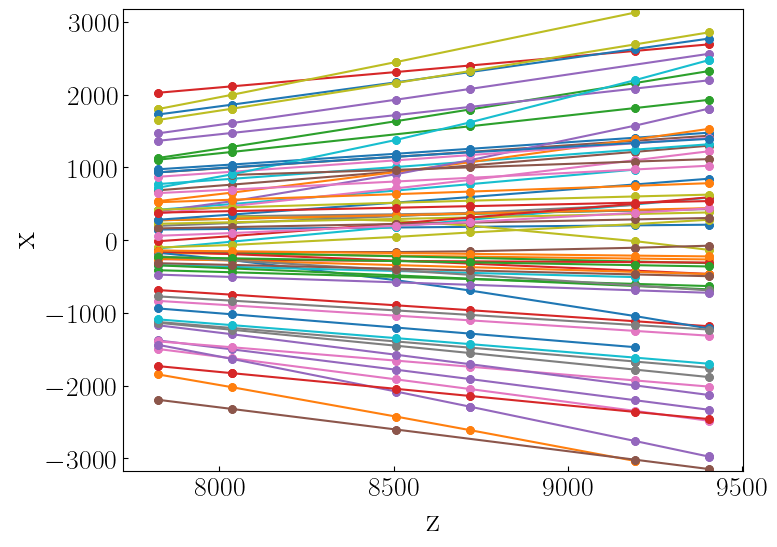

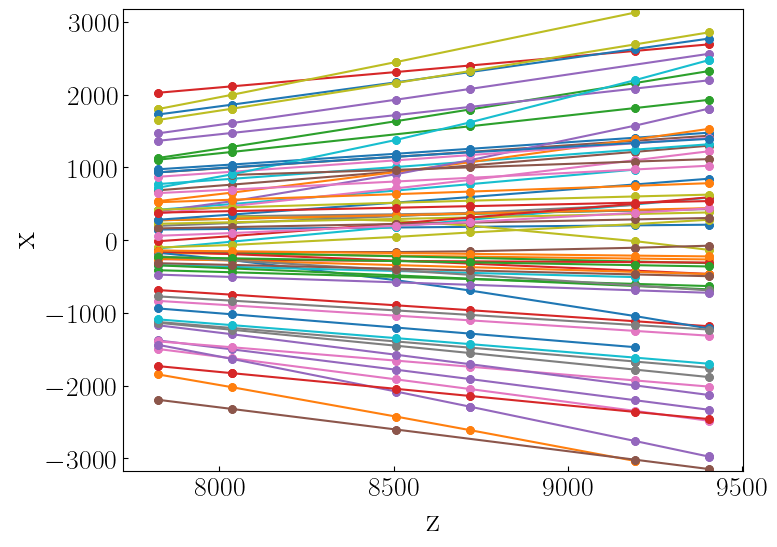

In [31]:
plot_xz_graph(
    df_hits_particles_true[(~df_hits_particles_true["has_velo"]) & df_hits_particles_true["has_scifi"]],
    n_tracks=10000,
    n_events=1,
)

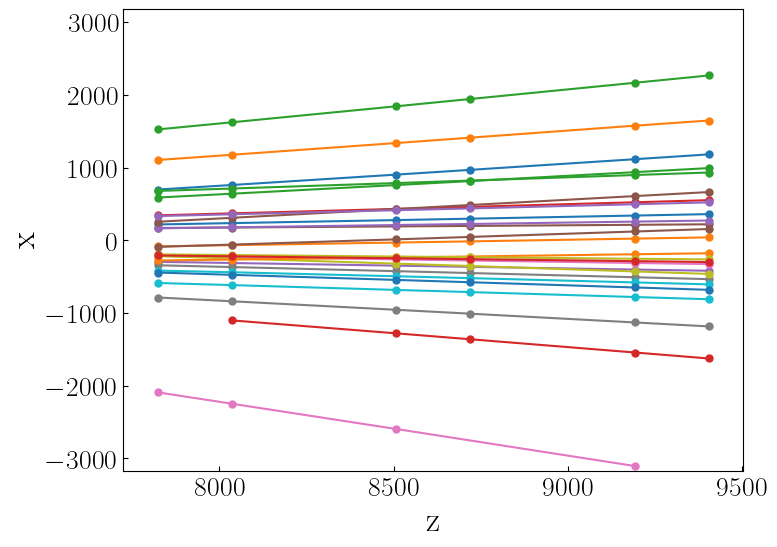

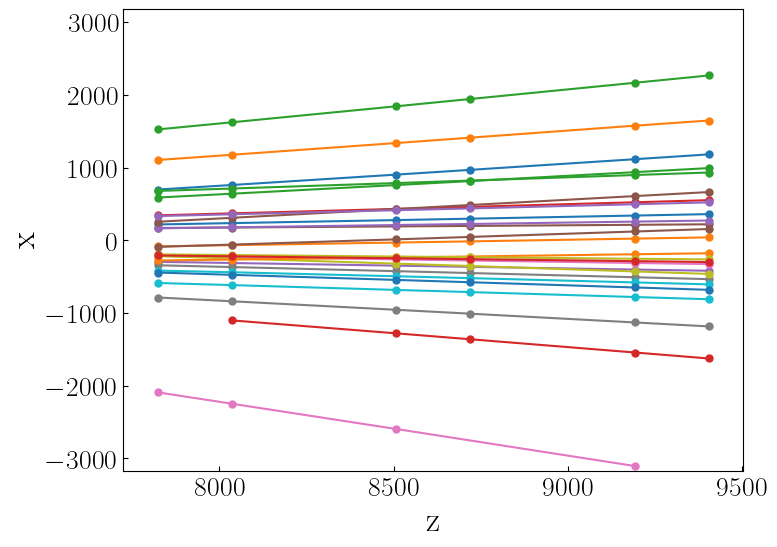

In [79]:
plot_xz_graph(
    df_hits_particles_true[(df_hits_particles_true["has_velo"]) & df_hits_particles_true["has_scifi"]],
    n_tracks=1000,
    n_events=1,
)